In [64]:
import pandas as PD
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [187]:
data = pd.read_csv("data.csv")

In [188]:
data

,Retirement,Debut Age (yrs),Longest Gap b/w innings,Time of best moving avg,No of innings,Time of worst moving avg,time of better score than 20% best scores
0,36.194521,0.881931,0.216917,0.715328,0.470790,0.532847,0.890511
1,29.063014,0.686733,0.694407,0.541667,0.082474,0.958333,0.666667
2,33.701370,0.667732,0.164393,0.405498,1.000000,0.934708,0.938144
3,38.660274,0.738469,0.223738,0.366038,0.910653,0.328302,0.939623
4,33.961644,0.816462,0.991814,0.812500,0.109966,0.312500,0.937500
5,38.032877,0.624547,0.545703,0.815029,0.594502,0.994220,0.930636
6,24.958904,0.696925,0.238745,0.800000,0.085911,0.440000,0.800000
7,37.706850,0.964070,0.282401,0.223214,0.384880,0.901786,0.767857
8,35.073973,0.753584,0.233970,0.515789,0.652921,0.463158,0.889474
9,25.400000,0.747452,0.186221,0.791667,0.082474,0.625000,0.708333


In [189]:
data.columns

Index(['Retirement', 'Debut Age (yrs)', 'Longest Gap b/w innings',
       'Time of best moving avg', 'No of innings', 'Time of worst moving avg',
       'time of better score than 20% best scores'],
      dtype='object')

In [190]:
# data["Age (yrs)"] = np.random.permutation(data["Age (yrs)"].values)
# data

In [191]:
#Set Target Variable
output_var = pd.DataFrame(data['Retirement'])
#Selecting the Features
features = [
	"Debut Age (yrs)",	"Longest Gap b/w innings",	"Time of best moving avg",	"No of innings",	"Time of worst moving avg",	"time of better score than 20% best scores"
    ]


In [192]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(data[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=data.index)
feature_transform.head()

,Debut Age (yrs),Longest Gap b/w innings,Time of best moving avg,No of innings,Time of worst moving avg,time of better score than 20% best scores
0,0.719417,0.098193,0.713368,0.427509,0.508069,0.743122
1,0.255542,0.648075,0.505872,0.007435,0.961737,0.217949
2,0.210386,0.037706,0.343175,1.000000,0.936547,0.854877
3,0.378489,0.106049,0.296027,0.903346,0.289977,0.858345
4,0.563834,0.990573,0.829470,0.037175,0.273128,0.853365


In [193]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=3)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [194]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [195]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(5))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [196]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
5/5 [==============================] - 2s 3ms/step - loss: 1152.1721
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 1149.0846
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 1145.8369
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 1142.3674
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 1138.5778
Epoch 6/100
5/5 [==============================] - 0s 2ms/step - loss: 1134.4244
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 1129.7610
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 1124.4908
Epoch 9/100
5/5 [==============================] - 0s 2ms/step - loss: 1118.5074
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 1111.6825
Epoch 11/100
5/5 [==============================] - 0s 2ms/step - loss: 1103.8873
Epoch 12/100
5/5 [==============================] - 0s 2ms/step - loss: 1095.0227
Epoch 13/100
5/5 [=======

In [197]:
y_pred= lstm.predict(X_test)

1/1 [==============================] - 0s 302ms/step


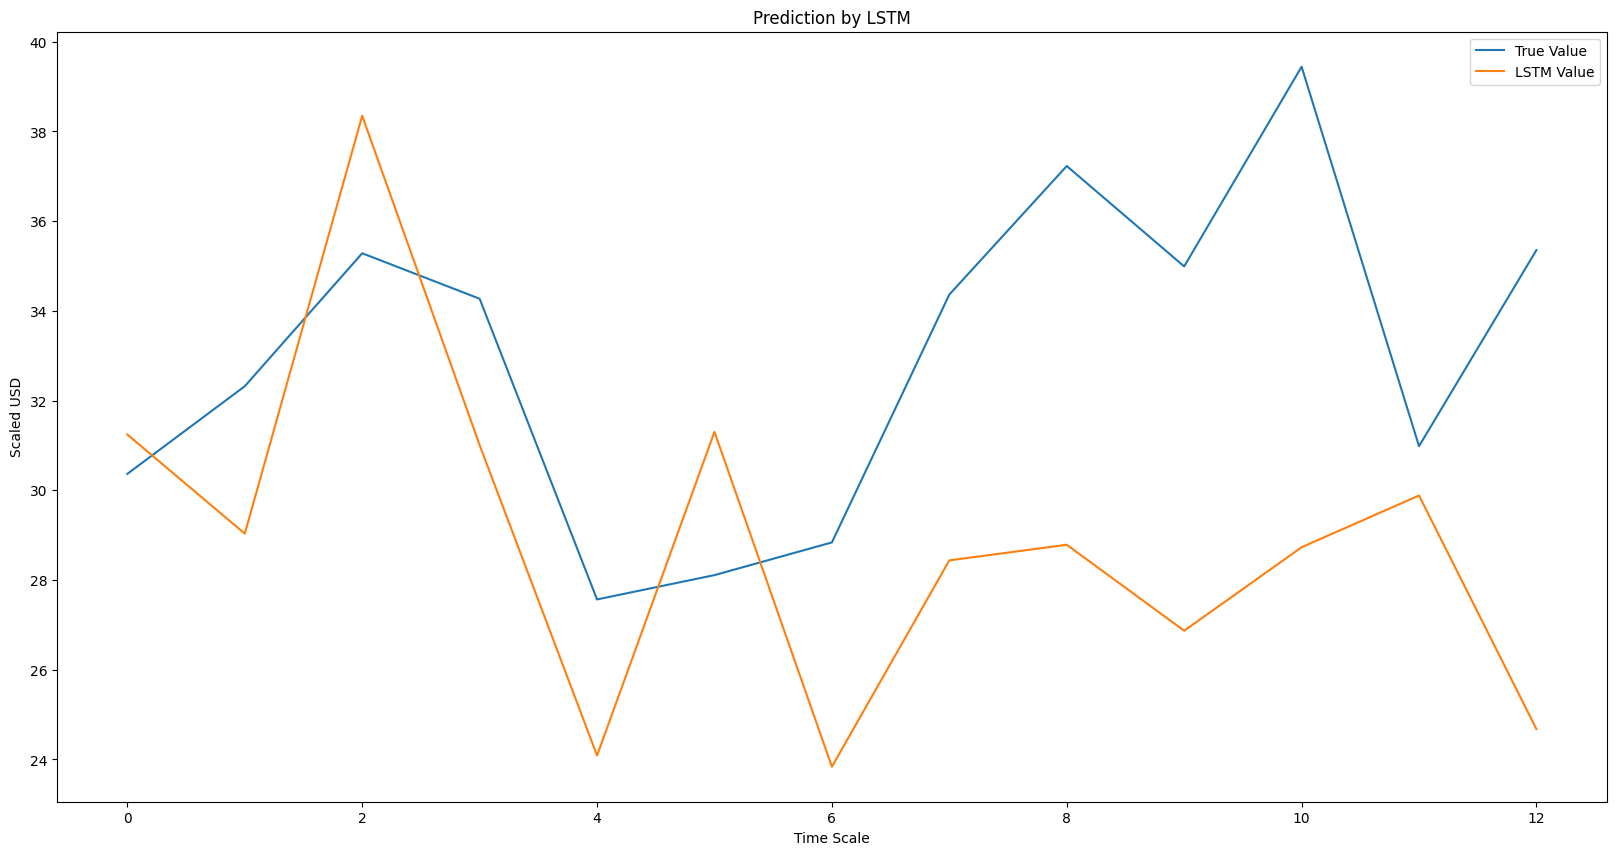

In [198]:
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()